Читаем библиотеки

In [2]:
!pip install tensorflow

You should consider upgrading via the 'c:\users\ifl\documents\github\.venv\scripts\python.exe -m pip install --upgrade pip' command.



  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=dfd7d04120ffac98603459188a712805b9b1f0bdb2c37b928e0054b5dca9e802
  Stored in directory: c:\users\ifl\appdata\local\pip\cache\wheels\f1\60\77\22b9b5887bd47801796a856f47650d9789c74dc3161a26d608
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=778c337561d48c078ee2619c2448dbc6403ef8392f9f4870ccc15da732bb708b
  Stored in directory: c:\users\ifl\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-win_amd64.whl size=33693 sha256=3d804c754e52bd1a2fef6195ae751595baf3c0915369524c58ee976bb8e1a2ec
  Stored in directory: c:\users\ifl\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built clang termcolor wrapt
  Attempting uninstall

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

Разбор текста - Токенизация

In [6]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(    num_words=10000)
# !wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt -O /tmp/sonnets.txt
data = open('./sonnets.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

In [7]:
corpus[:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

Исполним токенизацию и кодирование

In [8]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [9]:
token_list

[]

In [10]:
tokenizer.index_word[10]

'thou'

In [11]:
tokenizer.word_index['love']

14

In [12]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,   0,   0,   0,  16,  22,   2, 879,  61]])

In [13]:
label.shape

(15462, 3211)

Создаем сеть

In [14]:
callback = EarlyStopping(monitor='val_loss', patience=10) # создаем обратный вызов - calback - тут "Ранний останов"

In [15]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(128))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 256)           822016    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1605)              207045    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,383,047
Trainable params: 6,383,047
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
 history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
387/387 [==============================] - 21s 50ms/step - loss: 6.9780 - accuracy: 0.0239 - val_loss: 6.7319 - val_accuracy: 0.0162
Epoch 2/100
387/387 [==============================] - 20s 51ms/step - loss: 6.4825 - accuracy: 0.0230 - val_loss: 6.9008 - val_accuracy: 0.0165
Epoch 3/100
387/387 [==============================] - 20s 52ms/step - loss: 6.3722 - accuracy: 0.0244 - val_loss: 7.0230 - val_accuracy: 0.0255
Epoch 4/100
387/387 [==============================] - 20s 51ms/step - loss: 6.2593 - accuracy: 0.0348 - val_loss: 7.1018 - val_accuracy: 0.0239
Epoch 5/100
387/387 [==============================] - 19s 49ms/step - loss: 6.1281 - accuracy: 0.0411 - val_loss: 7.2217 - val_accuracy: 0.0272
Epoch 6/100
387/387 [==============================] - 19s 50ms/step - loss: 6.0104 - accuracy: 0.0440 - val_loss: 7.3443 - val_accuracy: 0.0255
Epoch 7/100
387/387 [==============================] - 19s 49ms/step - loss: 5.8861 - accuracy: 0.0456 - val_loss: 7.5321 - val_ac

Тест


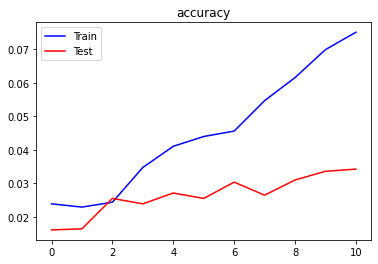

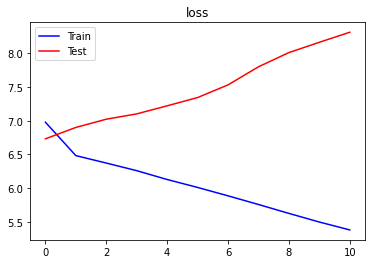

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Строим тест генератора

In [23]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
# 	predicted = model.predict_classes(token_list, verbose=0)
	predicted = model.predict(token_list, verbose=0)
  # 
	output_word = ""
	# добавим новое слово в последовательность
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

То что видим = зацикливание после 3-го добавленного слова (survey)


Посмотрим на предсказание через вероятные ответы (не олно слово имеет большую вероятность)

In [ ]:
y_p=model.predict(token_list)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [ ]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

In [ ]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p=model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

"Помогите мне, Оби Ван Кеноби, ты моя единственная надежда, покажи мне смертельные злые дела, новый день, новый день должен уйти, все я"